# Visualize Geospatial Data with Python
As opposed to visualizing using `AWS Quicksight`, we can also simply use various Python 3 libraries to get the job done.

### Dependencies

In [2]:
!pip3 install pandas numpy geopandas matplotlib descartes --user

# Clean and load the data
As the native output format we defined for `Kinesis` is somewhat odd, some simple cleaning is required. This can be done natively in Python as well.

In [3]:
%%bash
sed -i 's/""//' ../data/data_ar.json
sed -i "s/'//" ../data/data_ar.json

Looking at the data shows some valid coordinates.

In [86]:
import pandas as pd

df = pd.read_json('../data/data_ar.json', lines=True)
df.head()

,lat,long,altitude,timestamp,speed,id
0,33.740251,-94.313599,296.7,2019-08-06 22:43:48+00:00,18.323,0x380025a14d8e
1,33.740257,-94.313793,296.7,2019-08-06 22:43:49+00:00,18.145,0x380025a14d8e
2,33.740261,-94.313993,299.5,2019-08-06 22:43:50+00:00,17.804,0x380025a14d8e
3,33.740260,-94.314201,304.5,2019-08-06 22:43:51+00:00,17.532,0x380025a14d8e
4,33.740263,-94.314399,307.4,2019-08-06 22:43:52+00:00,17.312,0x380025a14d8e


In [87]:
df.describe()

,lat,long,altitude,speed
count,78.000000,78.000000,78.000000,78.000000
mean,33.740013,-94.321263,306.135897,16.795705
std,0.000255,0.004404,7.576158,5.001215
min,33.739676,-94.327432,290.100000,0.115000
25%,33.739793,-94.325268,299.750000,16.768500
50%,33.739897,-94.321423,305.350000,18.441500
75%,33.740294,-94.317451,314.475000,19.239000
max,33.740356,-94.313599,315.600000,21.272000


# Ways to visualize

## Geopandas
The easiest way is to simply plot the points using `geopandas`:

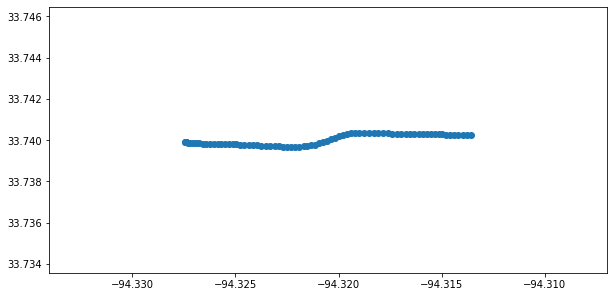

In [88]:
import geopandas as gpd
import matplotlib as plt
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
gdf.plot()

You can also project the points on a map:

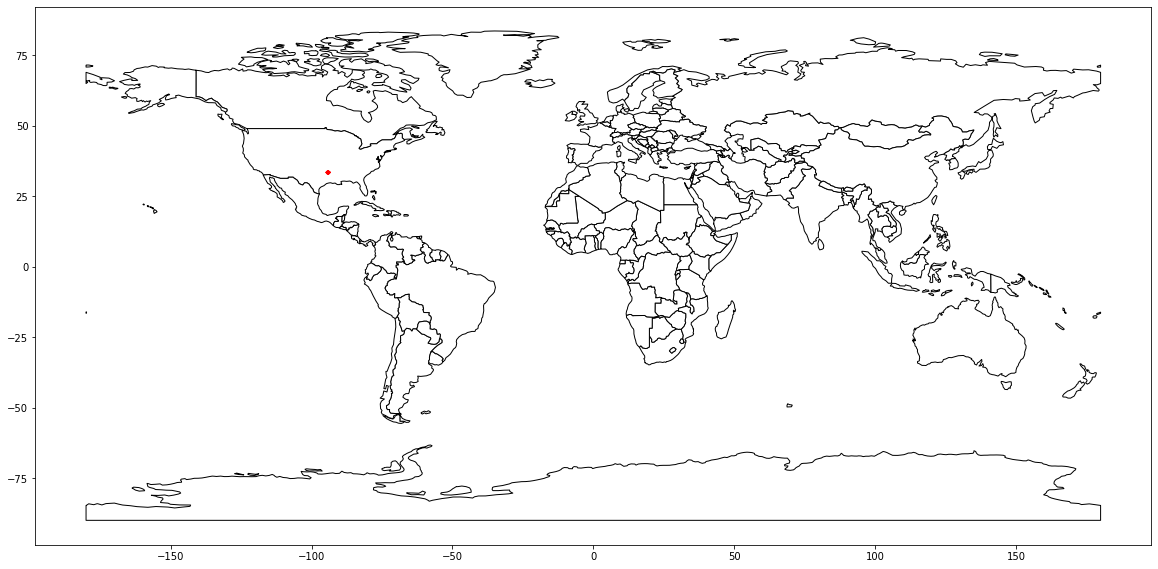

In [89]:
plt.rcParams["figure.figsize"] = (20,20)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', color='red', markersize=5)

## Geopandas and Shapefiles
Alternatively, we can use more detailled Shapefiles from [nationalmap.gov](https://nationalmap.gov/small_scale/atlasftp.html) and plot our data there.

Get the shapefile first and load it as `geopandas` dataframe.

In [ ]:
%%bash
wget https://prd-tnm.s3.amazonaws.com/StagedProducts/Small-scale/data/Boundaries/statesp010g.shp_nt00938.tar.gz
tar -xvzf statesp010g.shp_nt00938.tar.gz

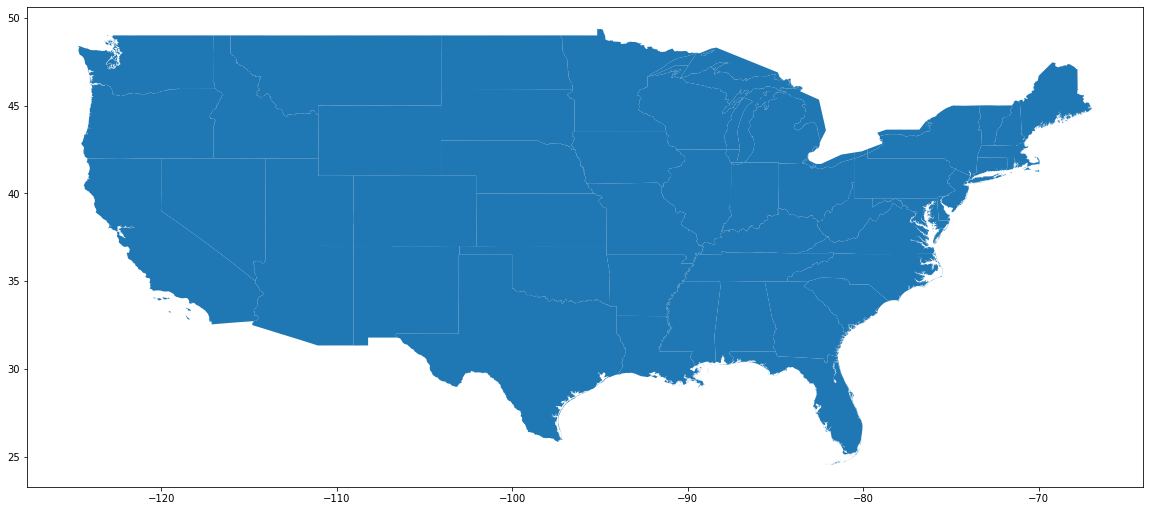

In [80]:
plt.rcParams["figure.figsize"] = (20,20)
import geopandas as gp
usa = gp.GeoDataFrame.from_file('./statesp010g.shp')#[['NAME', 'geometry']]
usa = usa[usa['STATE_ABBR'].apply(lambda s: s not in ['HI', 'PR', 'VI', 'AK'])]
usa.crs = {'init': 'epsg:43262' }
us = usa.plot()

It is trivial to filter she shapefile by a given state:

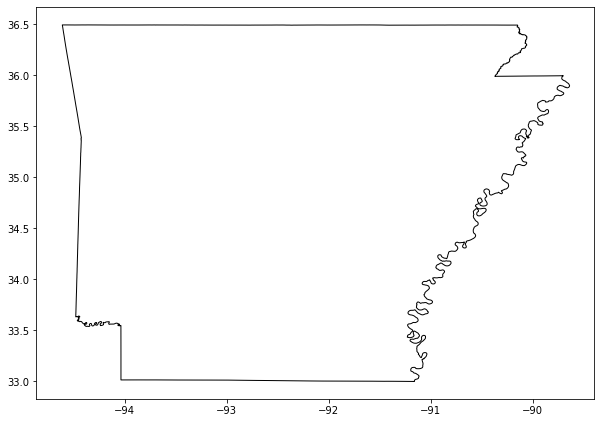

In [90]:
plt.rcParams["figure.figsize"] = (10,10)
ga = usa[usa.NAME == 'Arkansas'].plot(color='white', edgecolor='black')

And we can plot this by layering the `geopandas geometries` on top of the shapefile's map:

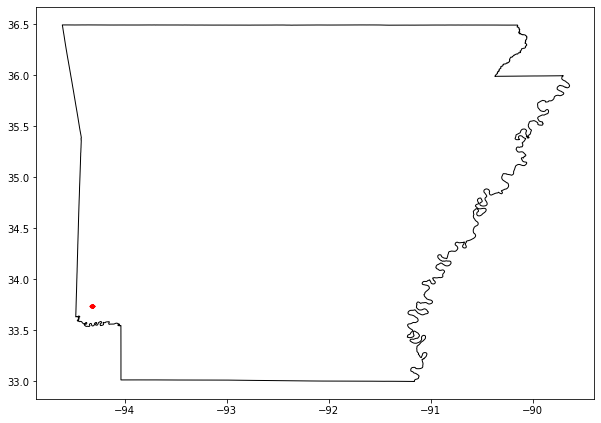

In [91]:
ga = usa[usa.NAME == 'Arkansas'].plot(color='white', edgecolor='black')
gdf.plot(ax=ga, marker='o', color='red', markersize=5)

## Fancy OpenStreetMap

For a more detailled view, we can use `folium`, which allows us to plot a `geopandas` dataframe on `OpenStreetMap` (OSM).

In [8]:
!pip3 install folium --user

In [92]:
avg_lat = df.mean()['lat']
avg_long = df.mean()['long']

In [93]:
import folium

mmap = folium.Map(location=[avg_lat, avg_long], zoom_start=12)
gdf.crs = {'init': 'epsg:4326'}

folium.GeoJson(gdf['geometry']).add_to(mmap)
mmap